In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.rcParams["font.family"] = 'Hiragino sans'
sns.set(font=['Hiragino sans'])

In [2]:
def RungeKutta4_spinup(initial, time, model, F):
    """
    initial :
        Initial state of x_i
    time : 
        time 
    record_time : 
        記録する時間ステップ
    model : 
        積分スキーム
    F :
        Forcing constant, to be used in Lorenz96
    kwargs : 
        modelに渡す x 以外の変数を指定
    """
    dt = time[1] - time[0]
    states = [initial]
    x = initial
    for t in time[:-1]:
        k1 = model(x, F)
        x1 = x + k1 * dt/2
        k2 = model(x1, F)
        x2 = x + k2 * dt/2
        k3 = model(x2, F)
        x3 = x + k3 * dt
        k4 = model(x3, F)
        x = x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
        states.append(x)
#         if t % record_time_step == 0:
#             states.append(x)
    states = np.stack(states)
    return states

In [3]:
def L96(x, F):
    """
    Lorenz 96 model with constant forcing.
    Cited by "https://en.wikipedia.org/wiki/Lorenz_96_model"
    
    Parameters
    ----------
    x : 
        variables
    F :
       Forcing constant 
    N : int
        number of sites
    """
    N = len(x)
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

# 積分

In [4]:
N = 40
F = 8.0
year = 2
# time step 0.2 = 1(d). 0.05 = 6(h)
# 2年分 0.2(/d) * 365(d) * 2(y) = 146
time = np.arange(0.0, 146.0, 0.05)

# 初期値をわずかに変えたもの
x1 = np.full(N, F)
x1[19] += F * 0.001
xs1 = RungeKutta4_spinup(x1, time, L96, F=F)

# 後半1年分のdata
dat = xs1[len(xs1)//2:]

In [5]:
xs1[1]

array([8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ,
       8.00000853, 8.00008107, 8.00060881, 8.00300985, 8.00736641,
       7.99878125, 7.99700745, 8.00024329, 8.00060879, 7.99996585,
       7.99991893, 8.        , 8.00000853, 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ])

## できているかの確認

In [6]:
from celluloid import Camera

In [7]:
%matplotlib widget
fig = plt.figure()
camera = Camera(fig)
for i in range(len(xs1)):
    if i % 4 == 0:
        t = plt.plot(xs1[i], color="green")
        plt.legend(t, [f'{i} unit time'], loc='upper left')
        camera.snap()
# animation = camera.animate(interval=300, blit=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Mersenne Twister

In [6]:
from numpy.random import Generator, MT19937
%matplotlib inline

In [41]:
seed = 46
rg = Generator(MT19937(seed))
# ノイズとして加えるデータ
rand = rg.standard_normal(dat.shape)
print(dat.shape)

(1460, 40)


## MTの乱数確認

58400


Text(0, 0.5, 'Count')

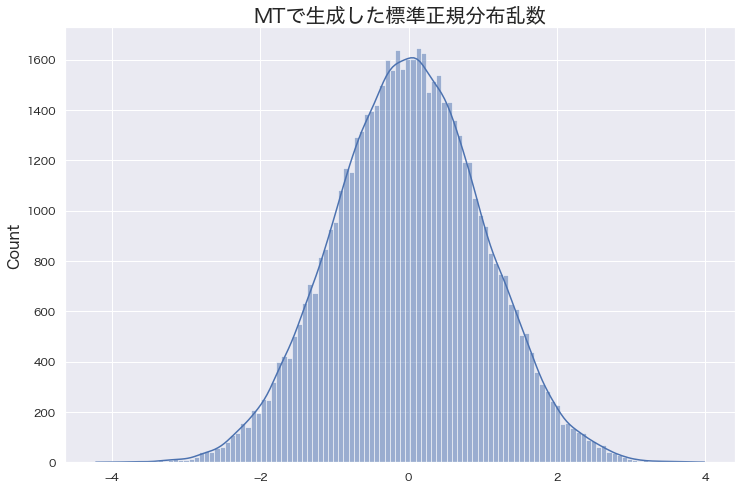

In [40]:
rand_flat = rand.flatten()
print(len(rand_flat))
plt.figure(figsize=(12, 8))
plot = sns.histplot(rand_flat, kde=True)
plot.set_title("MTで生成した標準正規分布乱数", fontsize=20)
plot.set_ylabel("Count", fontsize=15)

# plot.figure.savefig("../../pics/MT_normal_dist.png")

In [43]:
## 乱数をたくさん生成した時のヒートマップを加えた

In [25]:
for i in range(10000):
    seed = i
    rg = Generator(MT19937(seed))
    if i == 0:
        rand_ite = rg.standard_normal((40, 1))
    else:
        rand_val = rg.standard_normal((40, 1))
        rand_ite = np.concatenate([rand_ite, rand_val], axis=1)

In [35]:
rand_ite = np.transpose(rand_ite)

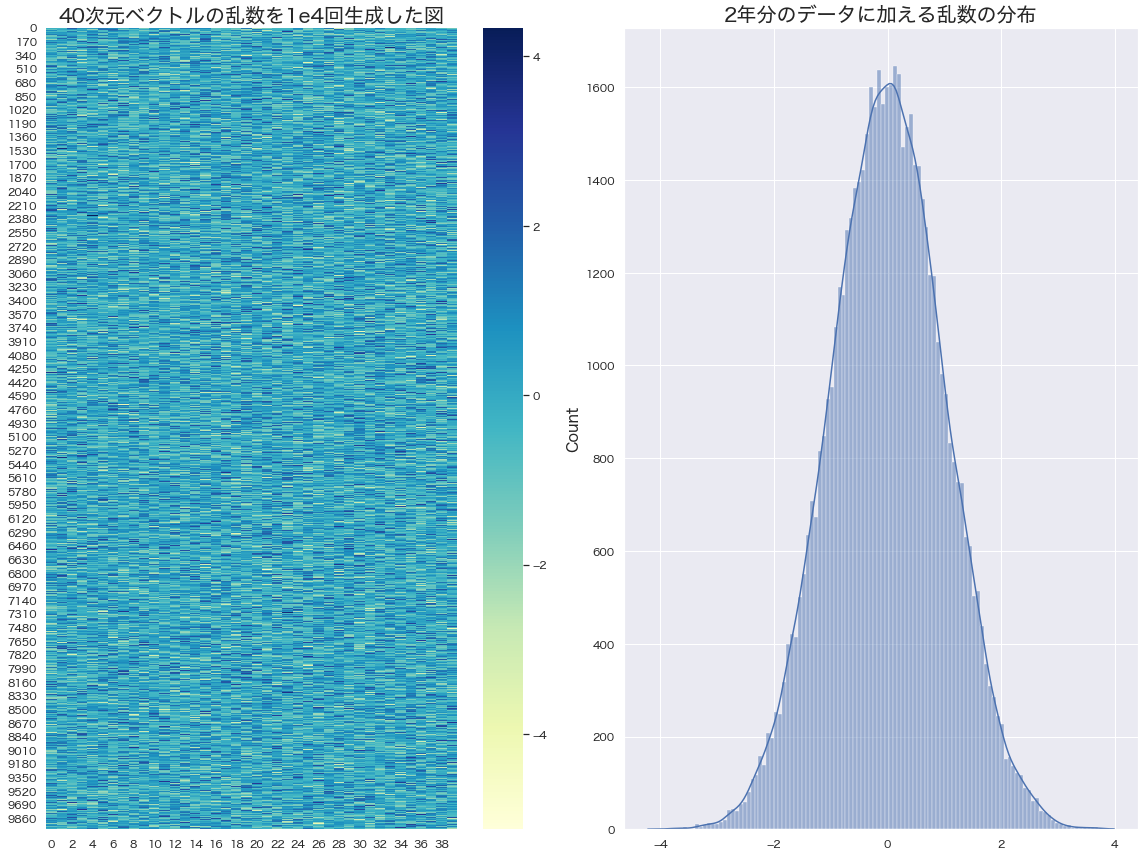

In [42]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(1, 2, 1)   #1行２列の１番目
sns.heatmap(rand_ite, cmap="YlGnBu", ax=ax1)
ax1.set_title("40次元ベクトルの乱数を1e4回生成した図", fontsize=20)
plot.set_ylabel("iteration", fontsize=15)

ax2 = fig.add_subplot(1, 2, 2)   #１行２列の２番目
plot = sns.histplot(rand_flat, kde=True, ax=ax2)
plot.set_title("2年分のデータに加える乱数の分布", fontsize=20)
plot.set_ylabel("Count", fontsize=15)

plt.tight_layout()
plt.show()

## 乱数追加

In [11]:
new_dat = dat + rand

In [12]:
# with open('../observed_dat.pickle', 'wb') as f:
#     pickle.dump(new_dat, f)

In [14]:
with open('../observed_dat.pickle', 'rb') as f:
    d = pickle.load(f)

In [17]:
d[0]

array([-0.07472501, -1.12753534,  0.41427903,  6.44095864,  2.77266813,
       -5.71481379,  2.90758377,  3.56003307,  6.11792043,  0.97508391,
        3.81111554,  6.31363435,  5.86246947,  4.05554332, -2.54630722,
       -2.31876332,  3.66335631,  2.75038576,  0.70309898,  5.34526583,
        5.84828614,  2.68757565,  5.32457802, -1.17060239,  3.15690907,
        7.9670818 ,  7.88261679, -1.21537452,  1.03488549,  8.67724671,
       -2.68126599,  3.16966431, -0.22678168,  6.53825022,  3.79300087,
       -2.31418604,  2.64682744,  6.80289455, -4.52823104, -1.43735165])